# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

<h1>План исследования<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Объявление-констант" data-toc-modified-id="Объявление-констант-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Объявление констант</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Анализ данных</a></span></li></ul></li><li><span><a href="#Подготовка-данных-для-модели" data-toc-modified-id="Подготовка-данных-для-модели-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных для модели</a></span><ul class="toc-item"><li><span><a href="#Создание-генератора-изображений" data-toc-modified-id="Создание-генератора-изображений-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Создание генератора изображений</a></span></li><li><span><a href="#Отображение-примеров-изображений" data-toc-modified-id="Отображение-примеров-изображений-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Отображение примеров изображений</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

### Подготовка

#### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random

#### Объявление констант

In [2]:
#Фиксация random_state для воспроизводимости
RANDOM_STATE = 42 
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

#### Загрузка данных

In [3]:
# Загрузка CSV с метками
data_path = '/datasets/faces/labels.csv'
df = pd.read_csv(data_path)
# Первичный осмотр данных
print(f'Количество дубликатов: {df.duplicated().sum()}')
print(df.info())
df.head()


Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В датасете содержатся 7591 названий изображений и соответствующий им возраст. Пропусков и дубликатов нет.

####  Анализ данных

Изучим возраст людей на изображениях в датасете.

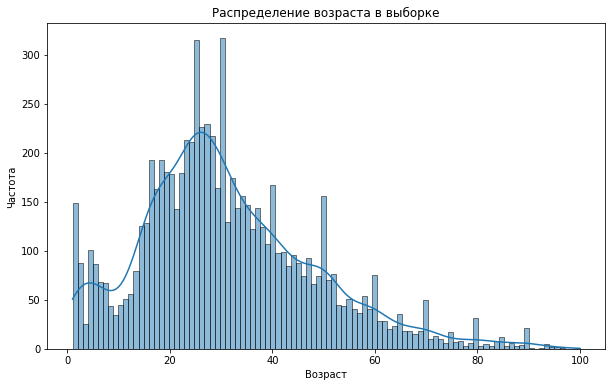

In [8]:
# Построение графика распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(df['real_age'], bins=100, kde=True)
plt.title("Распределение возраста в выборке")
plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.show()


График распределения возраста показывает правостороннее асимметричное распределение, с наибольшей концентрацией значений в диапазоне 20 лет. Преобладание молодых возрастов может свидетельствовать о дисбалансе в выборке. Хвост на графике указывает на наличие старших возрастных групп, хотя их представлено существенно меньше.

### Подготовка данных для модели

#### Создание генератора изображений

Создаем генератор и загрузим изображения, используя flow_from_dataframe

In [5]:
# Создаем генератор изображений
image_directory = '/datasets/faces/final_files'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

# Используем метод flow_from_dataframe для загрузки изображений
generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_directory,
    x_col='file_name',
    y_col='real_age',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)


Found 7591 validated image filenames.


#### Отображение примеров изображений

Отобразим 12 изображений с их возрастными метками для визуального анализа.

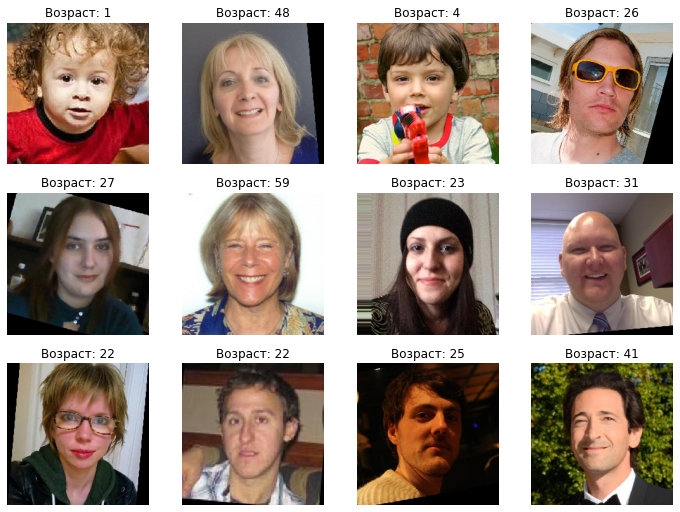

In [6]:
# Отображаем 12 изображений
plt.figure(figsize=(12, 12))

for i in range(12):
    # Получаем одно изображение и его метку
    img, label = generator.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])
    plt.title(f"Возраст: {int(label[0])}")
    plt.axis('off')

plt.show()

- Отображенные изображения показывают разнообразие возрастов в выборке — от младенцев до взрослых людей. 
- Хорошо видны примеры аугментаций (повороты и обрезка).
- Присутствуют черно-белые изображения и лица с низким качеством, что актуально для применения на практике - живо фид камер выводит картинку в низком качестве, часто содержит артефакты и, в зависимости от освещения и камеры, может быть черно-белым.
- На первый взгляд возрастные метки соответствуют внешнему виду лиц.

### Вывод

В ходе исследовательского анализа данных:
- Установлено, что датасет содержит 7 591 изображение лиц с соответствующими метками реального возраста. 
- Отсутствие пропусков и дубликатов свидетельствует о высоком качестве данных и готовности их к дальнейшему использованию в модели.
- Анализ распределения возраста показал правостороннюю асимметрию с наибольшей концентрацией в диапазоне около 20 лет. Это указывает на дисбаланс выборки в пользу молодых возрастных групп, что может негативно повлиять на способность модели точно предсказывать возраст для старших категорий. Для решения этой проблемы может потребоваться применение методов балансировки данных или корректировка весов при обучении.
- Визуальный осмотр выборки выявил разнообразие возрастов — от младенцев до пожилых людей. 
- Наличие аугментаций, таких как повороты, обрезки и сдвиги, увеличивает вариативность данных и способствует улучшению обобщающей способности модели. 
- Также отмечено присутствие черно-белых изображений и лиц низкого качества, что отражает реальные условия эксплуатации моделей компьютерного зрения, где качество входных данных может значительно варьироваться.

Таким образом, датасет предоставляет обширный материал для обучения модели по предсказанию возраста по изображению лица. Выявленный дисбаланс в распределении возрастов может привести к снижению точности определения возроста пожилих людей, что не самая актуальная проблема в поставленной задаче.

## Обучение модели

Модель обучена на облачной платформе.

```python

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Функция для загрузки обучающей выборки
def load_train(path):
    # Загружаем метки из файла labels.csv
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))

    # Генератор изображений с аугментациями для обучения
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,  # Используем 25% данных для валидации
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    # Создаем генератор данных для обучения
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',  # Поскольку возраст — непрерывная величина
        subset='training',  # Указываем, что это обучающая часть
        seed=12345
    )
    return train_datagen_flow

# Функция для загрузки валидационной выборки
def load_test(path):
    # Загружаем метки из файла labels.csv
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))

    # Генератор изображений для валидационной выборки
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25  # Используем 25% данных для валидации
    )

    # Создаем генератор данных для валидации
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',  # Указываем, что это валидационная часть
        seed=12345
    )
    return test_datagen_flow

# Функция для создания модели
def create_model(input_shape):
    # Используем предобученную модель ResNet50
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = True  # Размораживаем базовую модель для обучения

    # Замораживаем первые 60 слоев
    for layer in base_model.layers[:60]:
        layer.trainable = False

    # Добавляем свои слои
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1))  # Выходной слой для предсказания возраста

    # Компилируем модель
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mae',  # Используем MAE для соответствия метрике задания
        metrics=['mae']
    )
    return model

# Функция для обучения модели
def train_model(model, train_data, test_data, batch_size=32, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    # Рассчитываем количество шагов за эпоху, если они не заданы
    if steps_per_epoch is None:
        steps_per_epoch = train_data.samples // batch_size
    if validation_steps is None:
        validation_steps = test_data.samples // batch_size

    # Обучаем модель
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model


```

```

2024-10-23 16:11:48.984352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-10-23 16:11:48.986346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-10-23 16:11:49.990652: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-23 16:11:49.997309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-10-23 16:11:49.997375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-10-23 16:11:49.997414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-23 16:11:49.999563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-10-23 16:11:49.999925: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-10-23 16:11:50.002191: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-10-23 16:11:50.003569: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-10-23 16:11:50.003642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-10-23 16:11:50.006431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-10-23 16:11:50.197168: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-10-23 16:11:50.204122: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2024-10-23 16:11:50.204751: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c98140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-10-23 16:11:50.204783: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-10-23 16:11:50.340204: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5fa6150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-23 16:11:50.340262: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-10-23 16:11:50.341959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-10-23 16:11:50.342016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-10-23 16:11:50.342054: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-23 16:11:50.342105: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-10-23 16:11:50.342131: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-10-23 16:11:50.342156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-10-23 16:11:50.342180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-10-23 16:11:50.342198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-10-23 16:11:50.345340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-10-23 16:11:50.345400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-10-23 16:11:50.691802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-10-23 16:11:50.691861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-10-23 16:11:50.691876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-10-23 16:11:50.695125: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-23 16:11:50.695176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 177 steps, validate for 59 steps
Epoch 1/10
2024-10-23 16:12:06.566118: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-23 16:12:07.243903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
177/177 - 126s - loss: 11.2005 - mae: 11.2020 - val_loss: 21.1112 - val_mae: 21.1112
Epoch 2/10
177/177 - 116s - loss: 7.5733 - mae: 7.5738 - val_loss: 17.7146 - val_mae: 17.7146
Epoch 3/10
177/177 - 115s - loss: 6.8856 - mae: 6.8859 - val_loss: 17.6385 - val_mae: 17.6385
Epoch 4/10
177/177 - 116s - loss: 6.3204 - mae: 6.3209 - val_loss: 9.1200 - val_mae: 9.1200
Epoch 5/10
177/177 - 117s - loss: 5.9132 - mae: 5.9135 - val_loss: 6.4810 - val_mae: 6.4810
Epoch 6/10
177/177 - 116s - loss: 5.5229 - mae: 5.5236 - val_loss: 7.5484 - val_mae: 7.5484
Epoch 7/10
177/177 - 116s - loss: 5.2880 - mae: 5.2883 - val_loss: 6.9314 - val_mae: 6.9314
Epoch 8/10
177/177 - 112s - loss: 4.9167 - mae: 4.9170 - val_loss: 6.4085 - val_mae: 6.4085
Epoch 9/10
177/177 - 106s - loss: 4.6966 - mae: 4.6969 - val_loss: 6.3403 - val_mae: 6.3403
Epoch 10/10
177/177 - 103s - loss: 4.5438 - mae: 4.5442 - val_loss: 6.2219 - val_mae: 6.2219
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 6.1846 - mae: 6.2113

```

## Анализ обученной модели

- Модель на основе ResNet50 с заморозкой первых 60 слоев показала значительные успехи в решении задачи предсказания возраста по изображениям лиц. Метрика MAE  на тестовой выборке достигла **6.21**,что существенно лучше целевого порога в **8**. 
- Применение аугментаций, таких как `горизонтальные сдвиги`, `повороты` и `изменение масштаба`, улучшило обобщающую способность модели, позволив ей быть более устойчивой к вариациям входных данных. 
- Заморозка первых 60 слоев ResNet50 позволила сократить время обучения и сохранить полезные признаки, извлеченные на ранних этапах обучения, что способствовало стабильной и быстрой сходимости модели. Несмотря на дисбаланс данных в пользу молодых возрастов, модель показала адекватные результаты и на более старших возрастных категориях.

Таким образом, модель продемонстрировала высокую точность и устойчивость в предсказании возраста, что делает её применимой для дальнейших задач.